In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load and Pre-Process Data

In [15]:
parent_filepath = "../../../../Simulated WS Sampling/block_data"

sampleids = ["01_F", "01_G", "02_G", "02_H", "03_B", "03_H", "04_I", "04_N", "05_G", "05_I", "06_H", "07_K", "08_J", "09_E", "10_B", "11_E", "11_F", "12_M", "13_G", "14_I", "15_G", "16_B", "17_I", "18_E", "19_F", "21_I", "22_N", "23_B", "24_I", "25_M", "26_I", "27_H", "28_FSC", "29_L", "30_D"]

microns_per_pixel=0.22715
mm2_per_pixels2 = (microns_per_pixel / 1000) ** 2

font_dict = {"fontsize": 16, "fontweight": "bold", "fontname": "Arial"}

In [3]:
# Whole-slide stats generated from wholeslide_stats.ipynb
ws_stats = pd.read_excel("../../../../Data/WS_stats.xlsx")

ws_stats = ws_stats.rename(columns={"sample": "sampleid", "annotation": "region", "density": "ws_density", "n_neighbour": "ws_n_neighbour"})

ws_stats = ws_stats[ws_stats["region"].isin(["tumour", "outer_IM"])].reset_index(drop=True)

In [4]:
# Requisite files available in Figshare
# https://doi.org/10.6084/m9.figshare.28991807.v2

# Get Revised TMA locations and sampleids ===========================
tma_map = pd.read_excel("../../../../Data/CD8IHC_RevisedCoreMap.xlsx")

tma_map = tma_map[["x", "y", "PatientID", "BlockDesignation", "Revised Location", "Exclusion"]]

tma_map = tma_map[~tma_map["Exclusion"].isin(["LN", "X"])].reset_index(drop=True)

tma_map["(Row, Column)"] = [xy for xy in zip(tma_map["x"], tma_map["y"])]

tma_map = tma_map[tma_map["PatientID"] != 0].reset_index(drop=True)

tma_map["Revised Location"] = tma_map["Revised Location"].replace({"T": "tumour", "IM": "outer_IM"})

tma_map["sampleid"] = [f"{sample}_{block}" for sample, block in zip(tma_map["PatientID"], tma_map["BlockDesignation"])]

tma_map["sampleid"] = [f"0{sampleid}" if len(sampleid) == 3 else sampleid for sampleid in tma_map["sampleid"]]

tma_map = tma_map.drop(columns=["x", "y", "PatientID", "BlockDesignation", "Exclusion"])

tma_map_2 = pd.read_excel("../../../../Data/CD8IHC_RevisedCoreMap.xlsx")
tma_map_2 = tma_map_2[["x2", "y2", "Depth of Tumour- Core (mm)2"]]
tma_map_2 = tma_map_2.rename(columns={"Depth of Tumour- Core (mm)2": "tumour_depth"})
tma_map_2["(Row, Column)"] = [xy for xy in zip(tma_map_2["x2"], tma_map_2["y2"])]
tma_map_2 = tma_map_2.drop(columns=["x2", "y2"])

tma_map = tma_map.merge(tma_map_2, on="(Row, Column)", how="left")
# ====================================================================

# Get TMA densities ==================================================
tma_data = pd.read_csv("../../../../Data/TMA_CD8_SummaryData_MPIHC.csv")
tma_data = tma_data[["Spot Valid", "Case", "Location", "TMA Row", "TMA Column", "(Row, Column)", "CD8 Cells", "Tissue Area (μm²)"]]

tma_data = tma_data[tma_data["Spot Valid"] == 1].reset_index(drop=True)

tma_data["region"] = tma_data["Location"].replace({"T": "tumour", "IM": "outer_IM"})

tma_data["Area (mm)"] = tma_data["Tissue Area (μm²)"] / 1e6

tma_data["Density (mm)"] = tma_data["CD8 Cells"] / tma_data["Area (mm)"]

tma_data["(Row, Column)"] = [ast.literal_eval(xy) for xy in tma_data["(Row, Column)"]]

tma_data = tma_data.drop(columns=["Case", "TMA Row", "TMA Column", "Spot Valid", "Location", "Tissue Area (μm²)"])
# ====================================================================

tma_data = tma_data.merge(tma_map, on="(Row, Column)", how="left")

tma_data = tma_data[tma_data["sampleid"].isin(sampleids)].reset_index(drop=True)

In [5]:
# Excluded cores have no tumour_depth
tma_data

,"(Row, Column)",CD8 Cells,region,Area (mm),Density (mm),Revised Location,sampleid,tumour_depth
0,"(1, 1)",216.0,tumour,0.781910,276.246516,tumour,04_I,NaN
1,"(1, 2)",157.0,tumour,0.873067,179.825729,tumour,04_I,NaN
2,"(1, 3)",232.0,tumour,1.141093,203.313929,tumour,04_I,NaN
3,"(1, 4)",1146.0,outer_IM,1.019212,1124.398546,outer_IM,04_I,0.651
4,"(2, 1)",117.0,tumour,0.943557,123.998909,tumour,06_H,NaN
...,...,...,...,...,...,...,...,...
155,"(13, 11)",1019.0,outer_IM,1.195227,852.557626,tumour,01_F,NaN
156,"(13, 12)",152.0,outer_IM,0.194482,781.564274,outer_IM,01_F,NaN
157,"(13, 13)",746.0,tumour,1.295595,575.797276,outer_IM,01_G,0.519
158,"(13, 14)",176.0,tumour,0.539882,325.997125,outer_IM,01_G,NaN


In [6]:
tma_tum = tma_data[tma_data["Revised Location"] == "tumour"].reset_index(drop=True)
tma_im = tma_data[tma_data["Revised Location"] == "outer_IM"].reset_index(drop=True)

In [7]:
ws_tum = ws_stats[ws_stats["region"] == "tumour"].reset_index(drop=True)
ws_im = ws_stats[ws_stats["region"] == "outer_IM"].reset_index(drop=True)

## IM vs CT Boxplots

In [8]:
ws_p = stats.wilcoxon(ws_im["ws_density"], ws_tum["ws_density"]).pvalue
tma_p = stats.mannwhitneyu(tma_im["Density (mm)"], tma_tum["Density (mm)"]).pvalue

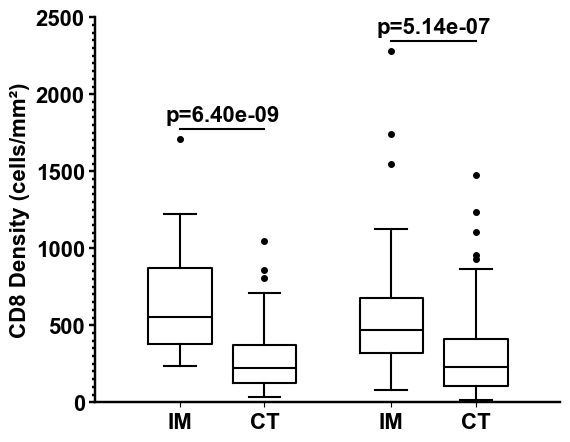

In [16]:
plt.subplots(figsize=(6, 5));

positions = [1, 2, 3.5, 4.5]

plt.boxplot([ws_im["ws_density"], ws_tum["ws_density"], tma_im["Density (mm)"], tma_tum["Density (mm)"]], tick_labels=["IM", "CT", "IM", "CT"], positions=positions, widths=0.75, flierprops={"marker": "o", "markerfacecolor": "black", "markersize": 4}, medianprops={"color": "black", "linewidth": 1.5}, boxprops={"color": "black", "linewidth": 1.5}, whiskerprops={"color": "black", "linewidth": 1.5}, capprops={"color": "black", "linewidth": 1.5});

x_max = 5.5
x_min = 0.0
plt.xlim(x_min, x_max)

y_min = 0.0
y_max = 2500
plt.ylim(y_min, y_max)

wsmin, wsmax, tmamin, tmamax = [(x - x_min) / (x_max - x_min) for x in positions]

plt.axhline(y=ws_stats["ws_density"].max() + 0.025 * y_max, color="black", linewidth=1.5, xmin=wsmin, xmax=wsmax)
plt.text(x=1.5, y=ws_stats["ws_density"].max() + 0.06 * y_max, s=f"p={ws_p:.2e}", ha="center", va="center", fontdict=font_dict)

plt.axhline(y=tma_data.sort_values("Density (mm)").reset_index(drop=True)["Density (mm)"].iloc[-1] + 0.025 * y_max, color="black", linewidth=1.5, xmin=tmamin, xmax=tmamax)
plt.text(x=4, y=tma_data.sort_values("Density (mm)").reset_index(drop=True)["Density (mm)"].iloc[-1] + 0.06 * y_max, s=f"p={tma_p:.2e}", ha="center", va="center", fontdict=font_dict)

plt.ylabel("CD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.yticks(fontsize=16, fontname="Arial", fontweight="bold")
plt.xticks(fontsize=16, fontname="Arial", fontweight="bold")

plt.gca().set_yticks(np.arange(0, 2550, 50), minor=True)

plt.gca().tick_params(axis="y", which="major", length=4, width=1.75)
plt.gca().tick_params(axis="y", which="minor", length=2, width=1.75)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.gca().spines["left"].set_linewidth(1.75)
plt.gca().spines["bottom"].set_linewidth(1.75)

plt.savefig("../../../../Data/Plots/Density/IM_vs_CT_CD8_density.png", dpi=300, bbox_inches="tight", transparent=True)

## TMA vs WS Boxplots

In [12]:
# Brute force method to find depth of tumour core with 80% area
core_area = (0.6 ** 2) * np.pi
core_area_80 = core_area * 0.8

depth = 0.0
segment_area = 0.0

while segment_area < core_area_80:
    depth += 0.001
    segment_area = (0.6 ** 2) * (np.arccos((0.6 - depth) / 0.6)) - (0.6 - depth) * (2 * 0.6 * depth - depth ** 2) ** 0.5

print(f"Depth of tumour core with 80% area: {round(depth, 4)} mm")

Depth of tumour core with 80% area: 0.896 mm


In [13]:
tma_im = tma_im[(tma_im["tumour_depth"] >= 0.0) & (tma_im["tumour_depth"] <= depth)].reset_index(drop=True)

In [14]:
im_p = stats.mannwhitneyu(ws_im["ws_density"], tma_im["Density (mm)"]).pvalue
ct_p = stats.mannwhitneyu(ws_tum["ws_density"], tma_tum["Density (mm)"]).pvalue

In [15]:
im_p, ct_p

(0.8525639730669545, 0.9519225528580172)

In [11]:
font_dict = {"fontsize": 16, "fontweight": "bold", "fontname": "Arial"}

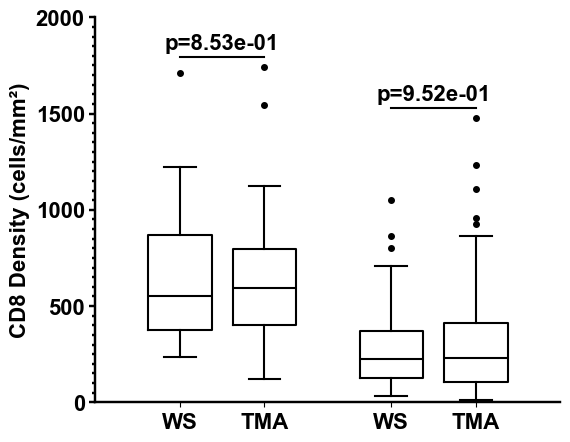

In [13]:
plt.subplots(figsize=(6, 5));

positions = [1, 2, 3.5, 4.5]

plt.boxplot([ws_im["ws_density"], tma_im["Density (mm)"], ws_tum["ws_density"], tma_tum["Density (mm)"]], tick_labels=["WS", "TMA", "WS", "TMA"], positions=positions, widths=0.75, flierprops={"marker": "o", "markerfacecolor": "black", "markersize": 4}, medianprops={"color": "black", "linewidth": 1.5}, boxprops={"color": "black", "linewidth": 1.5}, whiskerprops={"color": "black", "linewidth": 1.5}, capprops={"color": "black", "linewidth": 1.5});

x_max = 5.5
x_min = 0.0
plt.xlim(x_min, x_max)

y_min = 0.0
y_max = 2000
plt.ylim(y_min, y_max)

wsmin, wsmax, tmamin, tmamax = [(x - x_min) / (x_max - x_min) for x in positions]

plt.axhline(y=max(ws_im["ws_density"].max(), tma_im["Density (mm)"].max()) + 0.025 * y_max, color="black", linewidth=1.5, xmin=wsmin, xmax=wsmax)
plt.text(x=1.5, y=max(ws_im["ws_density"].max(), tma_im["Density (mm)"].max()) + 0.06 * y_max, s=f"p={im_p:.2e}", ha="center", va="center", fontdict=font_dict)

plt.axhline(y=max(ws_tum["ws_density"].max(), tma_tum["Density (mm)"].max()) + 0.025 * y_max, color="black", linewidth=1.5, xmin=tmamin, xmax=tmamax)
plt.text(x=4, y=max(ws_tum["ws_density"].max(), tma_tum["Density (mm)"].max()) + 0.06 * y_max, s=f"p={ct_p:.2e}", ha="center", va="center", fontdict=font_dict)

plt.ylabel("CD8 Density (cells/mm\u00b2)", fontdict=font_dict)

plt.yticks(np.arange(0, 2500, 500), fontsize=16, fontname="Arial", fontweight="bold")
plt.xticks(fontsize=16, fontname="Arial", fontweight="bold")

plt.gca().set_yticks(np.arange(0, 2050, 50), minor=True)

plt.gca().tick_params(axis="y", which="major", length=4, width=1.75)
plt.gca().tick_params(axis="y", which="minor", length=2, width=1.75)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.gca().spines["left"].set_linewidth(1.75)
plt.gca().spines["bottom"].set_linewidth(1.75)

plt.savefig("../../../../Data/Plots/Density/WS_vs_TMA_CD8_density.png", dpi=300, bbox_inches="tight", transparent=True)